# 03. Atmospheric maps from ERA5 atmospheric reanalysis
Data source:

DOI: 10.24381/cds.adbb2d47

## Import packages

In [2]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *


# OSI SAF sea ice drift
from LIB_OSI_SAF import grab_projinfo_OSISAF, grab_OSISAF_drift

# NSIDC sea ice drift
from LIB_PPdrift_NSIDC0116 import grab_projinfo_PPdrift

# ERA5
# from LIB_access_ERA5 import grab_ERA5

%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

### Grab atmos. fields by date

In [26]:

# specify date to import
#============================
date = datetime(2024, 1, 12)
#============================

file_path = '/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2024_daily.nc'

ds = xr.open_dataset(file_path)
ds.close


ds_date = ds.sel(expver = 1).sel(time = date)

ERA5 = {}

ERA5['time'] = ds_date.time.values
ERA5['lon'] = ds_date.longitude.values
ERA5['lat'] = ds_date.latitude.values

ERA5['lon_grid'], ERA5['lat_grid'] = np.meshgrid(ERA5['lon'], ERA5['lat'])

ERA5['u10'] = ds_date.u10.values
ERA5['v10'] = ds_date.v10.values
ERA5['msl'] = ds_date.msl.values


## Make map

Text(0.05, -0.1, 'sea level pressure (hPa)')

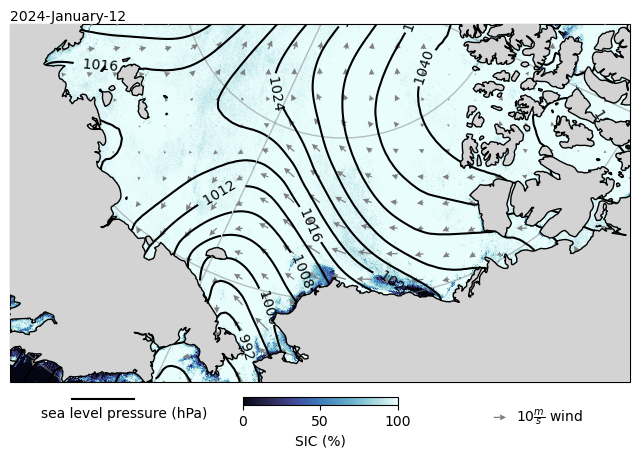

In [52]:

# specify date to plot
#============================
date = datetime(2024, 1, 12)
#============================

# read daily sic data from computer files into dictionary
data = grab_ASI_SIC(date=date, 
                    main_path='/Volumes/Jewell_EasyStore/UniB-ASI-SIC-n6250/', 
                    coord_file='LongitudeLatitudeGrid-n6250-Arctic.hdf', 
                    hemisphere='n', resolution='6250', version='v5.4', 
                    return_vars=['xx', 'yy', 'lon', 'lat', 'sic', 'proj', 'ds'], 
                    include_units=False, annual_folders=True, return_dict = True, quiet=True)

# create figure
#--------------
# create map figure in north polar stereographic projection
map_projection = ccrs.NorthPolarStereo(central_longitude=205)
fig, ax = plt.subplots(figsize=(8,8), subplot_kw=dict(projection=map_projection))

# background color
ax.patch.set_facecolor('lightgray')

# set map extent [lon1, lon2, lat1, lat2]
ax.set_extent([150, 250, 65, 85], crs=ccrs.PlateCarree())  

# add coastlines
ax.coastlines(zorder=100)

# add land
add_land(ax, scale='50m', color='lightgray', alpha=1, fill_dateline_gap=True, zorder=5)

# lat / lon lines
add_grid(ax, lats=np.arange(60,90,10), lons=np.arange(0,360,90), linewidth=1, color='gray', alpha=0.5, zorder=4)


# plot 2d sic data 
icec = ax.pcolormesh(data['xx'], data['yy'], data['sic'], 
                     cmap = cmocean.cm.ice, vmin=0, vmax=100, transform=data['proj'])

plt.colorbar(icec, label='SIC (%)', orientation='horizontal', shrink = 0.25, pad=0.025)


# label date
ax.text(0, 1, date.strftime('%Y-%B-%d'), ha='left', va='bottom', transform=ax.transAxes, clip_on=False)


# ERA5 10m wind field
qv1 = ax.quiver(ERA5['lon_grid'], ERA5['lat_grid'], *fix_cartopy_vectors(ERA5['u10'], ERA5['v10'], ERA5['lat_grid']), 
                regrid_shape = 15, color = 'gray', width = 0.002, headwidth=5, scale = 500, transform = ccrs.PlateCarree(), zorder=4)
qk = ax.quiverkey(qv1, 0.8, -0.1, 10, r'$10 \frac{m}{s}$ wind', labelpos='E',transform=ccrs.PlateCarree())

# ERA5 mean sea level pressure
line_c = ax.contour(ERA5['lon_grid'], ERA5['lat_grid'], ERA5['msl']/100, 
           levels = np.arange(960,1080,4), colors='k', transform = ccrs.PlateCarree(), zorder=4)

# Use the line contours to place contour labels.
ax.clabel(line_c,  # Typically best results when labelling line contours.
          colors=['black'],
          manual=False,  # Automatic placement vs manual placement.
          inline=True,  # Cut the line where the label will be placed.
          fmt=' {:.0f} '.format,  # Labes as integers, with some extra space.
          zorder=4
         )

ax.plot([0.1,0.2], [-0.05, -0.05], clip_on=False, c='k', transform=ax.transAxes)
ax.text(0.05, -0.1, 'sea level pressure (hPa)', c='k', transform=ax.transAxes)


# plt.show()


# save figure, if desired
# save_path = f'/Users/jewell/Desktop/map_{date.strftime("%Y-%m-%d")}.png'
# fig.savefig(save_path, dpi=300, bbox_inches = 'tight')